# Basic models of direction tuning

author: laquitainesteeve@gmail.com

execution time:

tested on:  
- Apple M4 16GB RAM (no GPU required)

**Method**:
- tuning parameters: standard deviations are based on literature data and we assume continuous neuron orientation and direction preferences.

## Setup 

activate fisher_info_limits

In [3]:
# import packages
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pickle5 as pickle
from scipy.stats import spearmanr, wilcoxon
from matplotlib.gridspec import GridSpec as GS
import math
from scipy.stats import poisson
from scipy.optimize import minimize_scalar
from scipy.special import radian as rad
from scipy.stats import circstd
from tqdm import tqdm
from scipy.special import gammaln
from scipy.optimize import curve_fit

# setup project path
main_dir = '/Users/steeve_laquitaine/Desktop/FISHER-paper/code/fisher-info-limits/'
os.chdir(main_dir)

# import custom package
import ssiProjectModule as ssiMod

# setup parameters
sample_size = 500
theta_step = 2
stim = np.arange(0, 360, theta_step) # stimulus direction space

# setup Bayesian parameters
N_TRIALS = 500

# setup paths
dat_dir_in = main_dir + 'data/decoding_analysis/'
data_dir = 'data/bayer_decoding_error/'+f'Bayes_Dec_Errs_{sample_size}reps_thetastep{theta_step}'+'.npz'
title = f'Stretch_BioQuads_multiplied_w_mean_g__theta_step={theta_step}_original_g_20240509_AREA.pkl'

constant = 360/np.sqrt(2*np.pi*math.e)

with open(dat_dir_in + title, 'rb') as rick:
    data_dict = pickle.load(rick)

bio_idx = np.where(data_dict['all_multipliers']==1.)[0][0]

chosen_quads = np.array([201, 125, 104, 491])

## Functions

In [4]:
# Bayesian decoder

def generate_responses(tuning_curves, true_direction_index, n_trials=10, seed=0):
    """
    Generate Poisson spike counts for all neurons given a true direction.
    
    Parameters:
    - true_direction_index: true motion direction index 
    - n_trials: number of trials to simulate
    
    Returns:
    - responses: array of spike counts [n_trials, n_neurons]
    """
    # setup reproducibility
    np.random.seed(seed)

    # parameters
    n_neurons = tuning_curves.shape[1]
    responses = np.zeros((n_trials, n_neurons))
    
    for n_i in range(n_neurons):
        mean_firing_rate = tuning_curves[true_direction_index, n_i]
        responses[:, n_i] = poisson.rvs(mean_firing_rate, size=n_trials)
    return responses


def log_likelihood(direction_index, responses, tuning_curves):
    """Compute log likelihood of observed responses given a direction.
    
    Parameters:
    - direction (float): candidate direction (degrees)
    - responses: observed spike counts for all neurons
    
    Returns:
    - log_likelihood: log probability of the data
    """
    n_neurons = tuning_curves.shape[1]
    direction_index = int(direction_index) # make an integer 

    log_prob = 0
    
    # Poisson log likelihood ( sum(r * ln(mean_r) - mean_r) )
    for n_i in range(n_neurons):
        mean_firing_rate = tuning_curves[direction_index, n_i]
        log_prob += responses[n_i] * np.log(mean_firing_rate + 1e-10) - mean_firing_rate - gammaln(responses[n_i] + 1)
    return log_prob


def compute_likelihood(responses, tuning_c):
    """Calculate likelihoods for all candidate directions given responses.
    
    Args:
        responses (np.array): vector of n neurons responses
        tuning_c (np.array): tuning curve matrix of shape (n_directions, n_neurons)
    """
    n_stim = tuning_c.shape[0]
    llh = []
    for candidate_dir_ix in range(n_stim):
        llh.append(log_likelihood(candidate_dir_ix, responses, tuning_c))
    return np.exp(np.array(llh))


def get_circular_mean(prob, directions):
    """Simplest form assuming 360 evenly spaced directions from 0° to 359°
    """
    # get directions
    dir = np.deg2rad(directions)
    
    # normalize probabilities
    prob = prob / np.sum(prob)
    
    # calculate components
    x = np.sum(prob * np.cos(dir))
    y = np.sum(prob * np.sin(dir))
    
    # return mean in degrees
    return np.degrees(np.arctan2(y, x)) % 360


def decode_direction(responses, tuning_c, stim):
    llh = compute_likelihood(responses, tuning_c)
    return get_circular_mean(llh, stim)


def compute_bayesian_decoding_error(true_directions, tuning_c, n_trials=100, seed=0):

    all_true_dirs = []
    all_decoded_dirs = []
    all_errors_deg = []
    all_errors_rad = []

    # loop over stimulus in stimulus space
    for dir_ix, true_dir in tqdm(enumerate(true_directions), total=len(true_directions)):

        # (n trials, 4 neurons) responses
        responses = generate_responses(tuning_c.T, int(dir_ix), n_trials=n_trials, seed=seed)

        # loop over many trials
        for trial in range(n_trials):
            
            #llh = compute_likelihood(responses[trial,:], tuning_c.T)
            #decoded_dir = get_circular_mean(llh, stim)
            decoded_dir = decode_direction(responses[trial,:], tuning_c.T, stim)
            
            # # decode each trial
            # decoded_dir_ix = decode_direction(responses[trial,:], 
            #                                   tuning_c.T, 
            #                                   bounds=(0, len(true_directions)-1))
            # decoded_dir = true_directions[decoded_dir_ix]

            # compute circular error
            error_deg = min(abs(decoded_dir - true_dir), 360 - abs(decoded_dir - true_dir))       
            error_rad = rad(error_deg, 0, 0)

            # record direction x trials
            all_true_dirs.append(true_dir)
            all_decoded_dirs.append(decoded_dir)
            all_errors_deg.append(error_deg)         
            all_errors_rad.append(error_rad)      

    all_true_dirs = np.array(all_true_dirs)
    all_decoded_dirs = np.array(all_decoded_dirs)
    all_errors_deg = np.array(all_errors_deg)
    all_errors_rad = np.array(all_errors_rad)

    # calculate estimate errors as std
    stds_deg = []
    stds_circ = []
    
    for _, true_dir in enumerate(true_directions):

        this_true_dir_pos = all_true_dirs== true_dir
        
        # method 1: std over degrees
        std_deg = np.sqrt((all_errors_deg[this_true_dir_pos]**2).mean())
        
        # method 2: circular std over radians
        std_circ = circstd(all_errors_rad[this_true_dir_pos])
        
        # record
        stds_deg.append(std_deg)
        stds_circ.append(std_circ)

    stds_deg = np.array(stds_deg)
    stds_circ = np.array(stds_circ)

    return {
        'true_directions': all_true_dirs,
        'decoded_directions': all_decoded_dirs,
        'errors_deg': all_errors_deg,
        'errors_rad': all_errors_rad,
        'stds_deg': stds_deg,
        'stds_circ': stds_circ
    }

## Compute dataset

### Tuning curves

In [5]:
# setup parameters
N_NEURONS = 20      # for a tiling with 20 neurons (Kriegeskorte, Nature, Rev, Neuro)
AMPLITUDE = 780     # for 19 spikes/secs (Albright, 1984)  (from Gaussian fit)
WIDTH = 0.29        # for 32 deg std (~75 deg FWHM), validated across species (from Gaussian fit)
BASELINE = 0

# setup the preferred angle of each neuron
preferred_angles = np.linspace(0, 360, N_NEURONS, endpoint=False) 
print('Preferred angles:', preferred_angles)

# create tuning curves
tuning_c = []
for ix, pref_angle  in enumerate(preferred_angles):
    tuning_c.append(ssiMod.VON_MISES(th=stim, a=AMPLITUDE, th_0=pref_angle, s=WIDTH, baseline=BASELINE))
tuning_c = np.array(tuning_c)
print("tuning curve shape:", tuning_c.shape)

Preferred angles: [  0.  18.  36.  54.  72.  90. 108. 126. 144. 162. 180. 198. 216. 234.
 252. 270. 288. 306. 324. 342.]
tuning curve shape: (20, 180)


## Compute metrics

- execution time: 

In [ ]:
%%time 

# FISHER INFO & ERROR 
# with a flat prior and unbiased estimator
fisher_info = ssiMod.FISHER_POISSON(stim, tuning_c)
fisher_error = 1/np.sqrt(fisher_info)

CPU times: user 1.67 ms, sys: 466 µs, total: 2.13 ms
Wall time: 1.81 ms


In [7]:
%%time

# BAYES ERROR
bayes_data = compute_bayesian_decoding_error(stim, tuning_c, n_trials=N_TRIALS, seed=0)

100%|██████████| 180/180 [07:03<00:00,  2.35s/it]

CPU times: user 7min, sys: 1.89 s, total: 7min 2s
Wall time: 7min 3s


In [5]:
%%time

# SSI 
ssi = ssiMod.MC_SSI2(tuning_c)

: 

## Plot

/var/folders/_k/b_712yyj7vn5l6zfgz7s3xmc0000gn/T/ipykernel_67094/4277144250.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


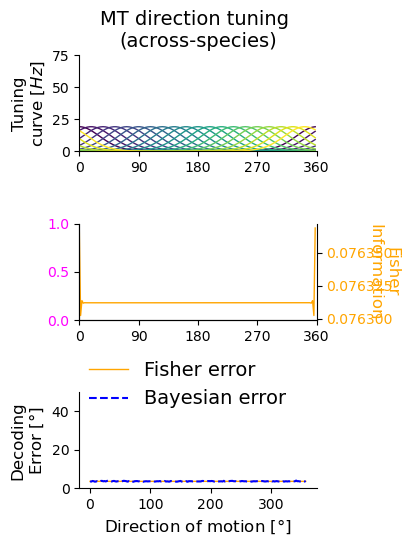

In [ ]:
# setup plot parameters
labelsize = 12
legend_fontsize = 14
text_size = 14
tick_labelsize = 10
lw = 1
plt.rcParams['xtick.labelsize']=tick_labelsize
plt.rcParams['ytick.labelsize']=tick_labelsize
mpl.rcParams['axes.spines.right']=False

# setup plot
fig = plt.figure(figsize=(15, 10))
gs = GS(5, 4, wspace=0.3, hspace=0.75)
#colors = ['blue', 'green', 'red', 'gold']

# Choose the colormap
cmap = plt.cm.viridis
values = np.linspace(0, 1, 20)
colors = [cmap(v) for v in values]




# plot tuning curves ----------------

ax = fig.add_subplot(gs[0,0])

for j, tc in enumerate(tuning_c):
    line = ax.plot(stim, tc, color = colors[j], linewidth=lw)

# legend
ax.set_xlim(0,360)
ax.set_ylim(0,75)    
ax.set_xticks(np.arange(0,361, 90))
ax.set_yticks(np.arange(0,76, 25))
# ax.legend(handles=line, frameon=False, fontsize = legend_fontsize, loc=(0.01, 0.75))
ax.set_title('MT direction tuning \n(across-species)', fontsize=legend_fontsize)




# plot Fisher information ----------------
# setup
ax1 = fig.add_subplot(gs[1,0])
ax2 = ax1.twinx()

# plot
ax1.plot(stim, ssis, color = 'magenta', linewidth=lw)
ax2.plot(stim, fisher_info, color = 'orange', linewidth=lw)

# aesthetics
ax2.spines['right'].set_visible(True)
ax1.tick_params('y', labelcolor = 'magenta')
ax2.tick_params('y', labelcolor = 'orange')
ax1.set_xlim(0,360)
ax1.set_xticks(np.arange(0,361, 90))
ax1.set_ylabel('Sensitivity\n'+r'[$Bits$]', color = 'magenta', size = labelsize)

ax.yaxis.set_label_coords(-0.135, y=0.5)
ax.set_ylabel('Tuning\n'+r'curve [$Hz$]', size = labelsize)  

ax2.yaxis.set_label_coords(1.35, y=0.5)
ax2.set_ylabel('Fisher\n'+r'Information', rotation=270, color = 'orange', size = labelsize)        

#gs.update(left=0.055,right=0.925,top=0.95,bottom=0.05)#,wspace=0.3,hspace=0.5)
#ax2.set_xlabel(r'Direction of motion [$\degree$]', size = labelsize)




# plot Fisher error ----------------

ax3 = fig.add_subplot(gs[2,0])
ax3.plot(stim, fisher_error, color = 'orange', linewidth=lw, label='Fisher error')
ax3.set_xlabel('Direction of motion [$\degree$]', size = labelsize)
ax3.set_ylabel('Decoding\n'+r'Error [$\degree$]', size = labelsize)  




# plot Bayes error ----------------

ax3.plot(stim, bayes_data['stds_deg'], color = 'blue', linestyle='--', label='Bayesian error')
ax3.set_ylim(0,50) 
ax3.legend(frameon=False, fontsize = legend_fontsize, loc=(0.01, 0.75))
plt.tight_layout()

plt.savefig('figures/fig1_basic_model.svg', bbox_inches='tight', dpi = 300)